In [84]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import pickle
import sys
import json
from scipy import stats

from collections import Counter 
sys.path.append("../../src/models/predict_model")
import predict_esi_rss
sys.path.append("../../src/visualization")
import esi_compare_viz
import esi_evaluation


pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', None)
pd.options.display.max_columns = None

In [85]:
pd.options.mode.chained_assignment = None  # default='warn'

## Read Data

In [86]:
with open('../../fileConfig.json') as config_file:    
        fileConfig = json.load(config_file)
  

In [87]:
fileESIThreshold_location = fileConfig['dataDirectory'] + fileConfig['resultDirectory'] + 'Predictions_2010.json'
df = json.load(open(fileESIThreshold_location))

In [88]:
ESI = df['ESI']
co_pred = df['co_pred']
rss_pred = df['rss_pred']
rss = df['rss']
co_bin = df['co_bin']
co_type = df['co_type']


In [89]:
unique, counts = np.unique(ESI, return_counts=True)
print 'original ESI:', dict(zip(unique, counts))

original ESI: {1: 345, 2: 2695, 3: 11432, 4: 7873, 5: 1850}


In [90]:
## capstone results
#ESI1 = 0.867605
#ESI2 = 0.672352

In [91]:
fileESIThreshold_location = fileConfig['dataDirectory'] + fileConfig['resultDirectory'] + 'esi_thresholds.json'  
with open(fileESIThreshold_location) as config_file:    
        thresholds = json.load(config_file)
thresholds

{u'esi1_threshold': 0.8709694147109985,
 u'esi2_threshold': 0.7043555974960327,
 u'rss_threshold': 0.35}

In [92]:
RSS_threshold = thresholds['rss_threshold']
ESI1 =thresholds['esi1_threshold']
ESI2 = thresholds['esi2_threshold']

In [93]:
reload(esi_evaluation)
new_esi = esi_evaluation.get_new_esi(rss_pred,co_pred,RSS_threshold,ESI1, ESI2)
print('New ESI:', Counter(new_esi))
len(new_esi)

('New ESI:', Counter({3: 11920, 5: 6523, 4: 2777, 2: 2306, 1: 669}))


24195

In [94]:
data_tuples = list(zip(ESI, co_pred, rss_pred, co_bin, co_type, new_esi))
cdc_info = pd.DataFrame(data_tuples, columns=['ESI', 'co_pred','rss_pred','co_bin','co_type','new_esi'])

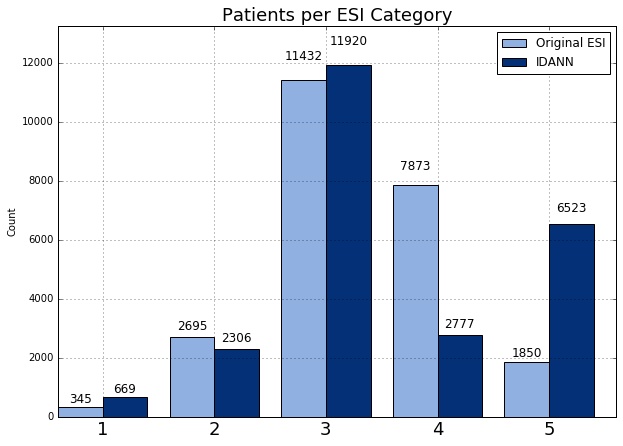

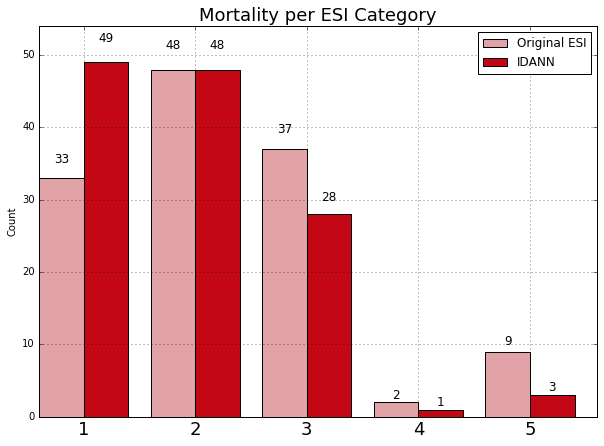

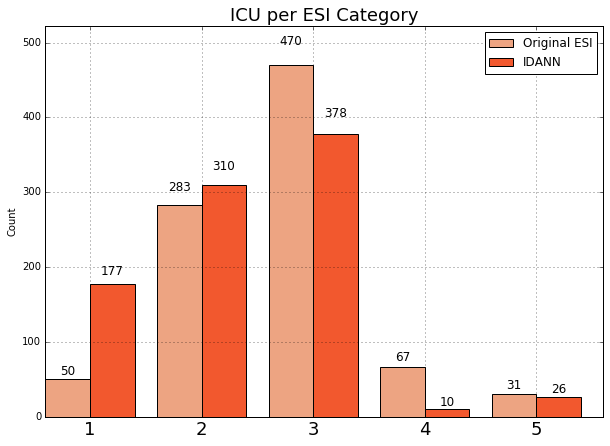

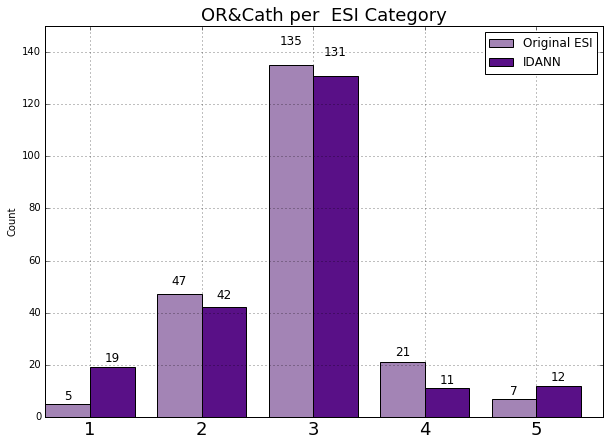

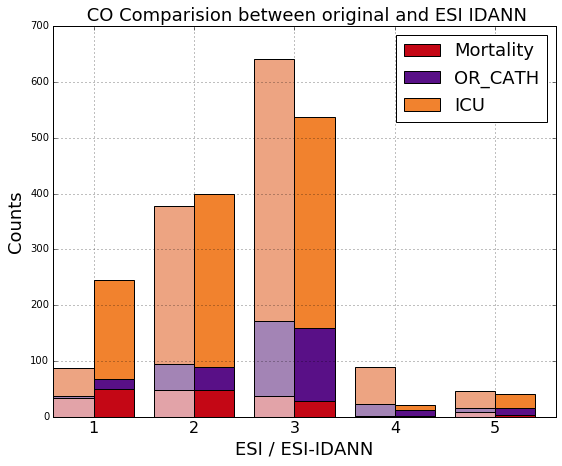

In [95]:

esi_compare_viz.show_esi_compare_viz(cdc_info)

In [96]:
# capstone results for critical outcomes 
#------------------------------------------
#     original_esi_counts  idann_esi_counts
#ESI                                       
#1                     88               210
#2                    378               423

In [97]:
esi_evaluation.show_co_caught_counts(cdc_info)

     original_esi_counts  idann_esi_counts
ESI                                       
1                     88               245
2                    378               400
3                    642               537
4                     90                22
5                     47                41
number of critical outcomes:  1245
original critical outcomes identified: 466
IDANN critical outcomes identified: 645


In [98]:
#Capstone TP and FP rates
#--------------------------------
#Baseline true positive rate: 37.429719%
#True positive rate: 50.843373%
#Baseline false positive rate: 11.215686%
#False positive rate: 9.764706%

In [99]:
reload(esi_evaluation)
esi_evaluation.show_tp_fp_rates(cdc_info)

Baseline true positive rate: 37.429719%
True positive rate: 51.807229%
Baseline false positive rate: 11.215686%
False positive rate: 10.152505%


## Testing for significant difference

In [100]:
nurse_assigned_tp=[]
nurse_assigned_fp=[]
idann_assigned_tp=[]
idann_assigned_fp=[]
for i in range(len(co_bin)):
    if ((ESI[i]==1 or ESI[i]==2) and co_bin[i]==1):
        nurse_assigned_tp.append(1)
    if (ESI[i]>=3 or ((ESI[i]==1 or ESI[i]==2) and co_bin[i]==0)):
            nurse_assigned_tp.append(0)      
    if ((ESI[i]==1 or ESI[i]==2) and co_bin[i]==0):
        nurse_assigned_fp.append(1)
    if (ESI[i]>=3 or ((ESI[i]==1 or ESI[i]==2) and co_bin[i]==1)):
            nurse_assigned_fp.append(0)            
    if ((new_esi[i]==1 or new_esi[i]==2) and co_bin[i]==1):
        idann_assigned_tp.append(1)
    if (new_esi[i]>=3 or ((new_esi[i]==1 or new_esi[i]==2) and co_bin[i]==0)):
            idann_assigned_tp.append(0)
    if ((new_esi[i]==1 or new_esi[i]==2) and co_bin[i]==0):
            idann_assigned_fp.append(1)
    if (new_esi[i]>=3 or ((new_esi[i]==1 or new_esi[i]==2) and co_bin[i]==1)):
            idann_assigned_fp.append(0)



In [101]:
#T-test for true positive rate between nurse and IDANN
t, p = stats.ttest_ind(nurse_assigned_tp, idann_assigned_tp)
print("t = " + str(t))
print("p-value = " + str(2*p))

t = -5.43454506944
p-value = 1.10402126445e-07


In [102]:
#T-test for false positive rate between nurse and IDANN
t2, p2 = stats.ttest_ind(nurse_assigned_fp, idann_assigned_fp)
print("t = " + str(t2))
print("p-value = " + str(2*p2))

t = 3.67594776791
p-value = 0.000474447956389
